# Environmetal sound classification


<a href="https://colab.research.google.com/github/GianmarcoLattaruolo/Vision_Project/blob/main/Vision_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis




Run this cell again if you modify some scripts.

In [14]:
import sys  
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
from scipy.io import wavfile
import seaborn as sb
sb.set(style="white", palette="muted")
import pandas as pd
import IPython.display as ipd
import random
from scipy import signal


#libraries
main_dir = os.getcwd()
module_path = main_dir
if module_path not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(module_path)

import importlib
imported_module = importlib.import_module("Preprocessing.data_loader")
importlib.reload(imported_module)
imported_module = importlib.import_module("Preprocessing.exploration_plots")
importlib.reload(imported_module)
imported_module = importlib.import_module("Preprocessing.clip_utils")
importlib.reload(imported_module)
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, power_spectrum_plot, plot_clip_overview

Run this cell once to download the dataset.


In [15]:
in_colab = 'google.colab' in sys.modules
if in_colab:
    print('Downloading the ESC-50 dataset')
    download_dataset('ESC-50')

## Base Exploration of the dataset

In this cell we can listen to one random audio in our dataset (different every time we run the cell). 
Moreover we visualize a portion of the audio.


The sample rate is44100
The data shape is (220500,)
Audio category: clock_tick


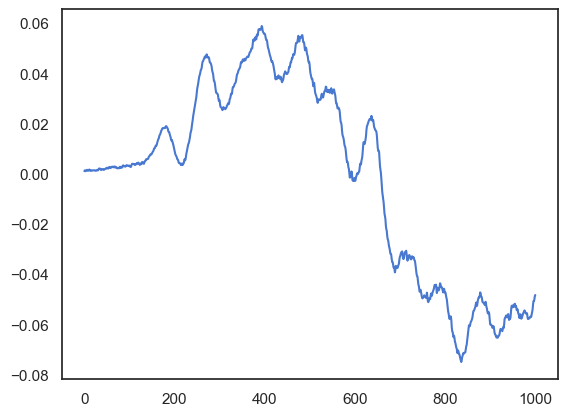

In [16]:
audio, samplerate = one_random_audio(main_dir)

frame length 882
overlap length 441
We are using 882 as length of the windowed signal after padding with zeros
Scipy STFT shape (442, 501)
Scipy; length of frequencies vector (442,)
Scipy; length of time vector (501,)
librosa STFT shape (442, 501)
Librosa frames to samples  has shape (501,), compute the time vector for STFT
Librosa fft_frequencies compute the frequencies given the sample_rate and the windowed length
Are the same as before? True
The STFT converted in decibell domain ha shape (442, 501)
Librosa Mel spectrogram of the audio has shape (128, 501) 
Librosa MFCC features has shape (40, 501)


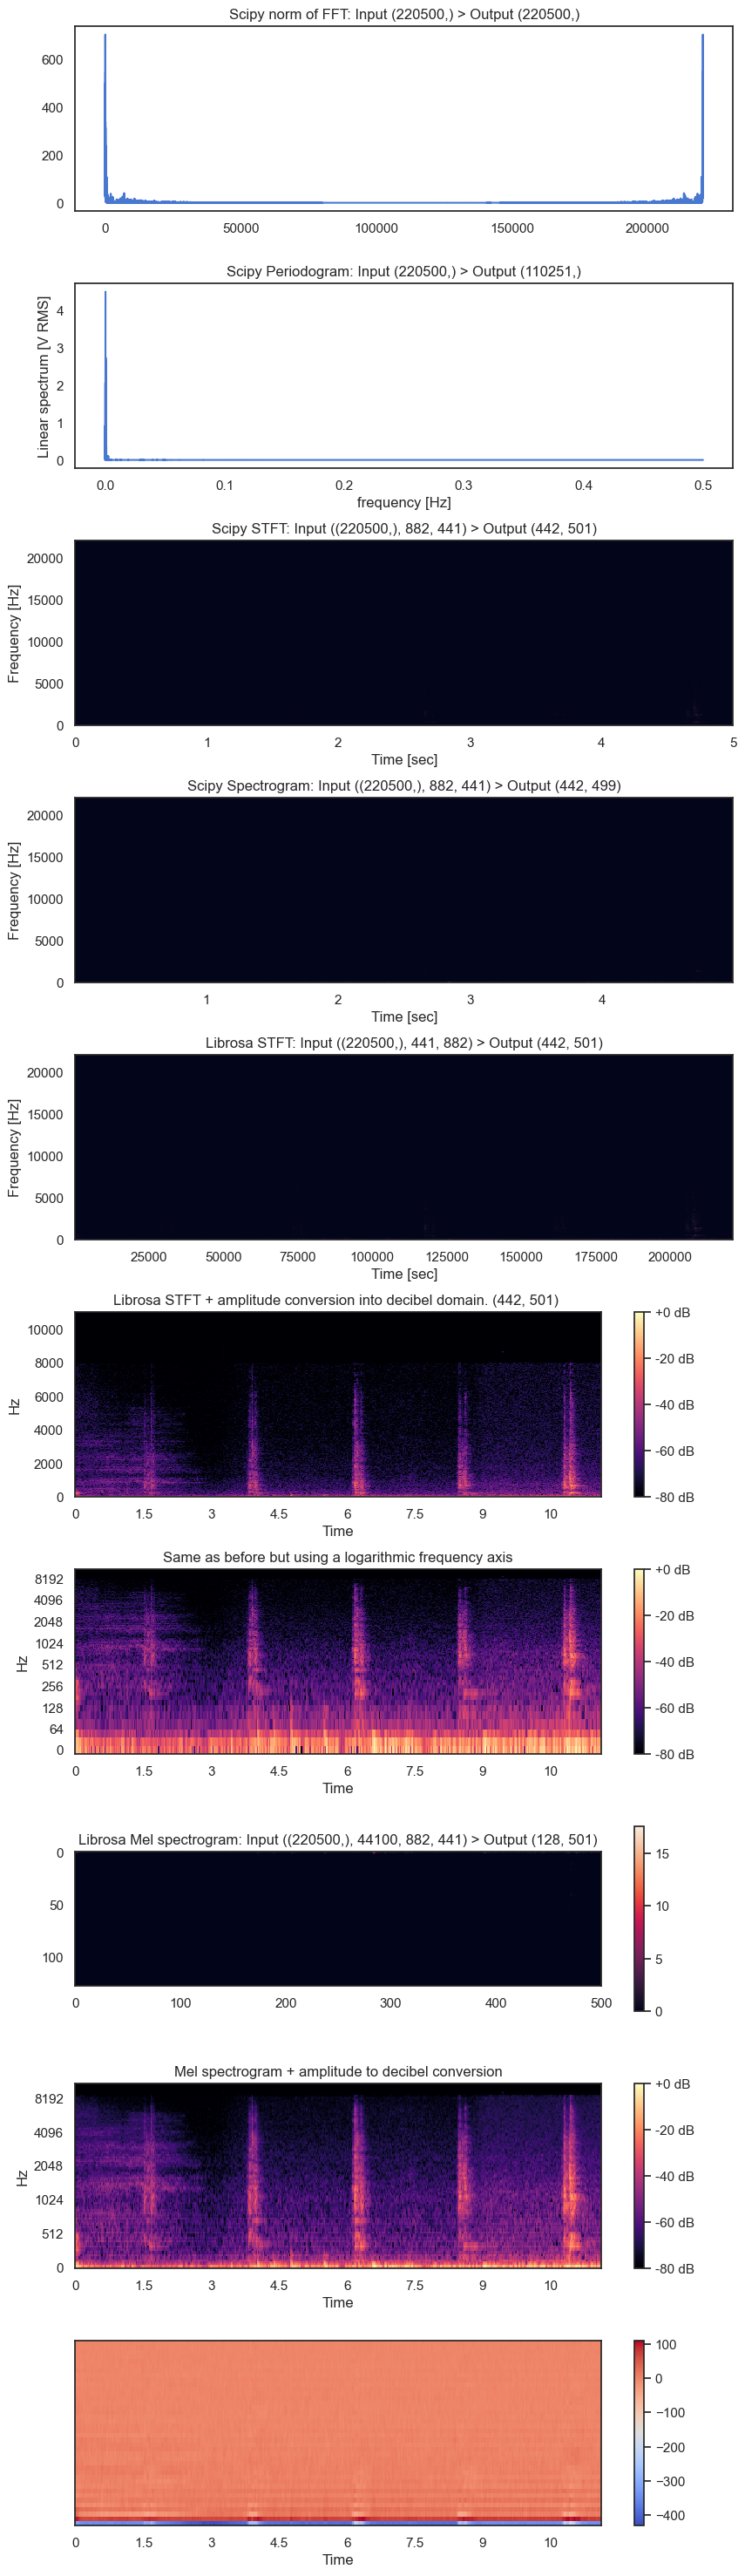

In [17]:
#type of spectrum, transformation windows ecc:
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram

sample_rate = 44100
segment=20
overlapping=10 #in milliseconds
cepstral_num = 40 #number of mel frequencies cepstral coefficients
N_filters = 50 #number of mel filters in frequency domain

nperseg = round(sample_rate * segment / 1000)  # Calculate the number of samples per segment win_length = nperseg
print(f'frame length {nperseg}')
noverlap = round(sample_rate * overlapping / 1000)
print(f'overlap length {noverlap}')
n_fft = nperseg
print(f'We are using {n_fft} as length of the windowed signal after padding with zeros')
hop_length = nperseg-noverlap

plt.subplots(10, 1, figsize=(9, 30))
plt.tight_layout(pad=3)
#plt.title(f': Input {.shape} > Output {.shape}')

# SCIPY

y_hat = fft(audio)
plt.subplot(10,1,1)
plt.plot(np.abs(y_hat))
plt.title(f'Scipy norm of FFT: Input {audio.shape} > Output {y_hat.shape}')

f, y_norm = periodogram(audio)
plt.subplot(10,1,2)
plt.plot(f , y_norm)
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.title(f'Scipy Periodogram: Input {audio.shape} > Output {y_norm.shape}')

freq, time, stft_y = stft(audio,fs = samplerate, window='hann', nperseg=nperseg, noverlap=noverlap, nfft=n_fft)
print(f'Scipy STFT shape {stft_y.shape}')
print(f'Scipy; length of frequencies vector {freq.shape}')
print(f'Scipy; length of time vector {time.shape}')
plt.subplot(10,1,3)
plt.pcolormesh(time, freq, np.abs(stft_y),shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'Scipy STFT: Input {audio.shape, nperseg, noverlap} > Output {stft_y.shape}')

f,t , spec_y = spectrogram(audio, fs = samplerate, nperseg=nperseg, noverlap=noverlap)
plt.subplot(10,1,4)
plt.pcolormesh(t, f, spec_y)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'Scipy Spectrogram: Input {audio.shape, nperseg, noverlap} > Output {spec_y.shape}')

#LIBROSA

frequencies = librosa.fft_frequencies(sr = sample_rate,n_fft=audio.shape[0]) #non so cosa sia

y_stft = librosa.stft(audio,hop_length = hop_length, win_length = nperseg, n_fft = n_fft)
print(f'librosa STFT shape {y_stft.shape}')
plt.subplot(10,1,5)
t = librosa.frames_to_samples([i for i in range(y_stft.shape[1])],hop_length=noverlap, n_fft=n_fft)
print(f'Librosa frames to samples  has shape {t.shape}, compute the time vector for STFT')
f = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
print(f'Librosa fft_frequencies compute the frequencies given the sample_rate and the windowed length')
print(f'Are the same as before? {[f==freq][0][0]}')
plt.pcolormesh(t, f, np.abs(y_stft))
plt.title(f'Librosa STFT: Input {audio.shape, hop_length, nperseg} > Output {y_stft.shape}')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')


S_db = librosa.amplitude_to_db(np.abs(y_stft), ref=np.max)
print(f'The STFT converted in decibell domain ha shape {S_db.shape}')
plt.subplot(10,1,6)
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.title(f'Librosa STFT + amplitude conversion into decibel domain. {S_db.shape} ')
plt.colorbar(format="%+2.f dB")


plt.subplot(10,1,7)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.title(f'Same as before but using a logarithmic frequency axis')
plt.colorbar(format="%+2.f dB")

#librosa other types of spectral data

mel_y = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft = n_fft, hop_length = hop_length, win_length=nperseg) 
print(f'Librosa Mel spectrogram of the audio has shape {mel_y.shape} ')#different da feature.mfcc
plt.subplot(10,1,8)
plt.imshow(mel_y)
plt.colorbar()
plt.title(f'Librosa Mel spectrogram: Input {audio.shape, samplerate, nperseg, hop_length} > Output {mel_y.shape}')


M_db = librosa.power_to_db(mel_y, ref=np.max)
plt.subplot(10,1,9)
librosa.display.specshow(M_db, y_axis='mel', x_axis='time')
plt.title(f'Mel spectrogram + amplitude to decibel conversion')
plt.colorbar(format="%+2.f dB")


#mel frequency cepstral coefficients
mfcc_y = librosa.feature.mfcc( y=audio, 
                              sr=sample_rate, 
                              n_mfcc=cepstral_num,
                              n_fft = n_fft,  
                              hop_length=hop_length, 
                              htk=True, 
                              fmin = 40,
                              n_mels = N_filters)
print(f'Librosa MFCC features has shape {mfcc_y.shape}')
plt.subplot(10,1,10)
librosa.display.specshow(mfcc_y, x_axis='time')
plt.colorbar()







Let's see a periodogram (power spectrum) for our clip.

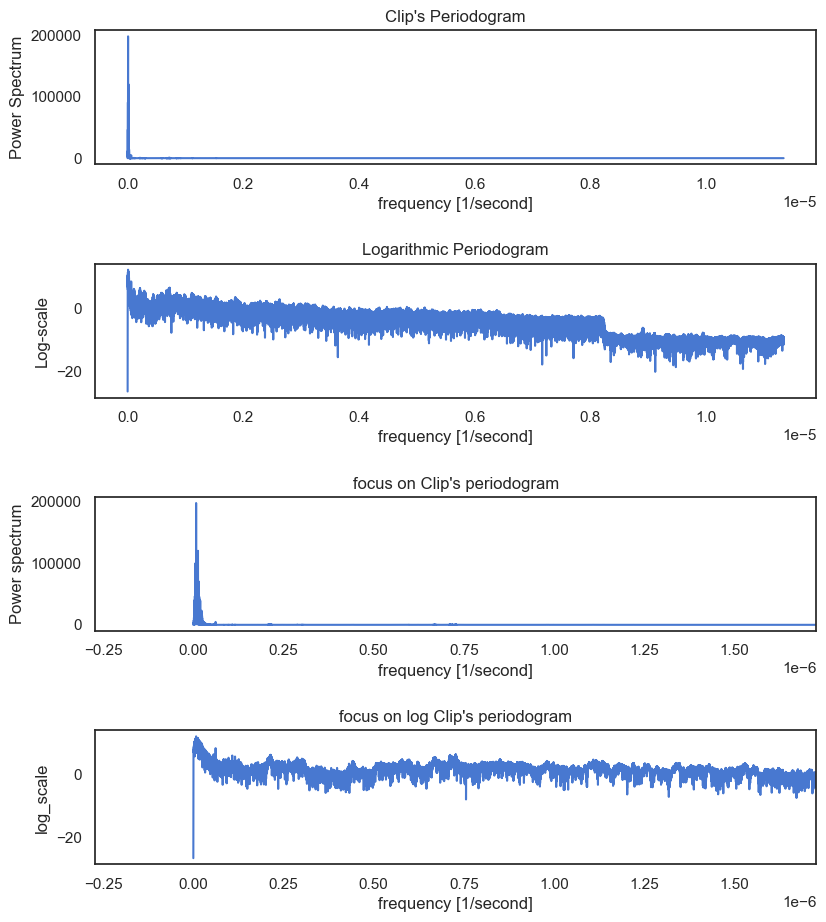

In [18]:
power_spectrum_plot(audio, samplerate)

We can say that, as we expected, this type of analysis on the entire audio clip is meaningless. We'll need to fragment the audio clips.
But first let's produce some summary statistics about our dataset.

In [19]:
df_ESC10, df_ESC50 , df_ESC_US = load_metadata(main_dir, ESC_US = True)
# default values are:
# heads = True, statistics = False, audio_listen = False, ESC50=True, ESC10=True, ESC_US=False

,filename,fold,target,category,esc10,src_file,take,full_path
0,1-100032-A-0.wav,1,0,dog,True,100032,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...


Classes in the full dataset  are perfectly balanced
 Counter({'dog': 40, 'chirping_birds': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'pouring_water': 40, 'train': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'car_horn': 40, 'crackling_fire': 40, 'helicopter': 40, 'drinking_sipping': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass_breaking': 40, 'snoring': 40, 'toilet_flush': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40})


,filename,fold,target,category,src_file,take,full_path
0,1-100032-A-0.wav,1,0,dog,100032,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
14,1-110389-A-0.wav,1,0,dog,110389,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
24,1-116765-A-41.wav,1,41,chainsaw,116765,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
54,1-17150-A-12.wav,1,12,crackling_fire,17150,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
55,1-172649-A-40.wav,1,40,helicopter,172649,A,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...


Classes in ESC10 
 ['dog', 'rain', 'rooster', 'chainsaw', 'crying_baby', 'sea_waves', 'clock_tick', 'helicopter', 'crackling_fire', 'sneezing']
Loading the 1/2 folder of unlabeled data 
Loading the 2/2 folder of unlabeled data 
We have 20000 unlabeled audios.


,filename,full_path
0,016514-31948-40-45.ogg,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
1,019507-35054-0-5.ogg,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
2,016972-32311-300-305.ogg,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
3,016774-32197-50-55.ogg,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...
4,014522-29650-260-265.ogg,/Users/leonardo/Desktop/HDA/Human_Data_Analyti...


## Spectrogram Analysis

Now we dig in the analysis exploiting the natural structure of sound in nature. 
In particular we'll need the [Short-Time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

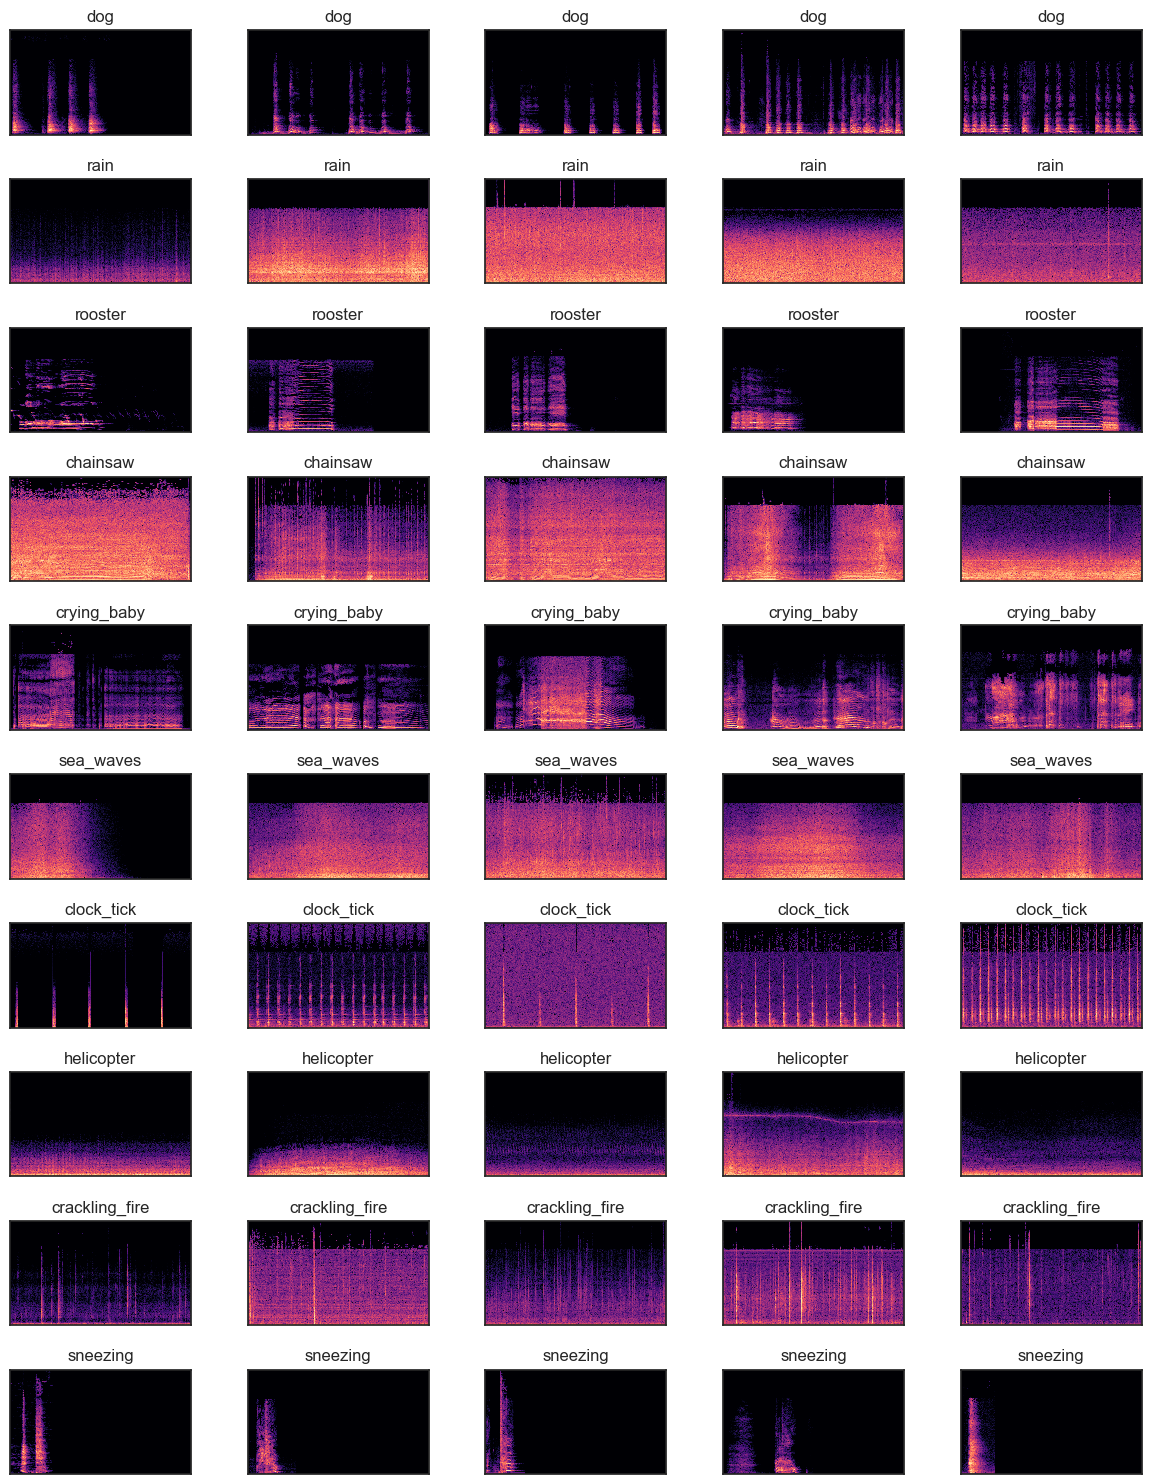

In [20]:
plot_clip_overview(df_ESC10) #clearly you can pass only df_ESC10 or df_ESC50

In [21]:
audio = os.path.join(main_dir,'data','ESC-50','1-137-A-32.wav')
y, sr = librosa.load(audio,sr=44100)
librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True)

array([[-4.5337439e+02, -5.6834198e+02, -5.0387729e+02, ...,
        -3.4366354e+02, -1.3529082e+02, -3.7128345e+02],
       [ 1.3434491e+02,  1.7694389e+02,  1.2607414e+02, ...,
         1.5418506e+02,  1.3391547e+02,  1.7108144e+02],
       [-8.1748438e+00, -3.6898050e+00, -7.4755493e+01, ...,
        -7.2405151e+01, -8.7364182e+01, -5.1034069e+01],
       ...,
       [ 2.1181242e+00,  5.0022650e+00,  3.5919719e+00, ...,
         8.3187742e+00,  8.8611698e+00, -4.1883123e-01],
       [-1.3518436e+00,  2.6005309e+00, -1.2373867e+00, ...,
         5.2695870e+00, -8.0891695e+00,  8.6519778e-01],
       [ 2.9803199e-01,  5.3931212e-01, -1.4929016e+00, ...,
        -8.0441837e+00, -9.1008205e+00, -8.1665707e+00]], dtype=float32)

## Pandas dataset

In [22]:

audio_paths = df_ESC10.full_path

audio_data = []
for audio_path in audio_paths:
    audio, _ = librosa.load(audio_path, sr=44100)  # Set sr=None to load the audio file with its original sampling rate
    audio_data.append(audio)
pd_df = pd.DataFrame({'audio': audio_data, 'target': df_ESC10['target']})
display(pd_df.head())

,audio,target
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
14,"[-0.0025634766, -0.0011291504, 0.00012207031, ...",0
24,"[-0.01260376, -0.015045166, -0.0154418945, -0....",41
54,"[0.0014343262, 0.0017700195, 0.0015563965, 0.0...",12
55,"[0.11935425, 0.1296997, 0.14428711, 0.20455933...",40


## Tensorflow dataset

In [23]:
import tensorflow as tf

def create_tf_dataset(metadata):
    #metadata is a pandas dataframe with the metadata of the audios 
    audio_paths = metadata['full_path']

    if 'target' in metadata.columns:
        targets = metadata['target'] 

        def load_audio(audio_path, target):
            audio_path = audio_path.numpy().decode()
            audio, _ = librosa.load(audio_path, sr=44100) 
            tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
            return tensor_audio, target
    
        tf_data = tf.data.Dataset.from_tensor_slices((audio_paths, targets))
        tf_data_map = tf_data.map(lambda audio_path, target: tf.py_function(load_audio, [audio_path, target], [tf.float64, tf.int32]))

    else:
        def load_audio(audio_path):
            audio_path = audio_path.numpy().decode()
            audio, _ = librosa.load(audio_path, sr=44100) 
            tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
            return tensor_audio
    
        tf_data = tf.data.Dataset.from_tensor_slices(audio_paths)
        tf_data_map = tf_data.map(lambda audio_path : tf.py_function(load_audio, [audio_path], [tf.float64, tf.int32]))

    return tf_data_map

In [24]:
tf_df = create_tf_dataset(df_ESC50)

for audio, target in tf_df:
    # Perform operations with audio and target tensors
    print(audio, target)
    break

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(220500,), dtype=float64) tf.Tensor(0, shape=(), dtype=int32)


In [25]:
import tensorflow as tf

metadata = df_ESC_US

audio_paths = metadata['full_path']

def load_audio(audio_path):
    audio_path = audio_path.numpy().decode()
    audio, _ = librosa.load(audio_path, sr=44100) 
    tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
    return tensor_audio
    
#tf_data = tf.data.Dataset.from_tensor_slices((audio_paths)) #QUESTO CREA PROBLEMI 
#tf_data_map = tf_data.map(lambda audio_path : tf.py_function(load_audio, [audio_path], [tf.float64, tf.int32]))

#for audio in tf_df:
    # Perform operations with audio and target tensors
    #print(audio)
    #break